In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import csv
import random
from matplotlib import pyplot as plt
import math
from tqdm.notebook import tqdm

from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import seaborn as sns 
from scipy.stats import pearsonr

In [2]:
# Import BDB 2023 Data
# Pass plays week 1-8 season 2021

games_df = pd.read_csv ('../input/nfl-big-data-bowl-2023/games.csv')
players_df = pd.read_csv ('../input/nfl-big-data-bowl-2023/players.csv')
plays_df = pd.read_csv ('../input/nfl-big-data-bowl-2023/plays.csv')
pff_df = pd.read_csv('../input/nfl-big-data-bowl-2023/pffScoutingData.csv')
weeks = []
for i in range(8):
    filename = '../input/nfl-big-data-bowl-2023/week'+str(i+1)+'.csv'
    weeks.append(pd.read_csv(filename))
weeks_df = pd.concat(weeks)

# merge scout data onto the tracking data 
weeks_df = weeks_df.merge(pff_df[['gameId', 'playId', 'nflId', 'pff_role','pff_positionLinedUp']], how='left')

# Import team color data from Lee Sharpe

teamcolors = pd.read_csv("https://raw.githubusercontent.com/leesharpe/nfldata/master/data/teamcolors.csv")

In [3]:
# get all plays that resulted in a sack or QB run
not_pass = ['qb_sack','qb_strip_sack']
no_pass_df = weeks_df.loc[weeks_df['event'].isin(not_pass)]
_gpf_nopass = no_pass_df.groupby(['gameId','playId','frameId']).size().reset_index().drop(columns=[0])
gpf_nopass = _gpf_nopass.rename(columns={'frameId':'event_frame'})

In [4]:
feats = []
target = []
OLteam = []
DLteam = []
gpid = []
for i, data in tqdm(gpf_nopass.iterrows()):
    one_play = weeks_df.loc[(weeks_df['gameId']==data.gameId)&(weeks_df['playId']==data.playId)]
    one_play['sec_til_event'] = (data.event_frame - one_play.frameId)/10
    snap_fr = one_play.loc[one_play['event'].isin(['autoevent_ballsnap', 'ball_snap'])].frameId.max()
    play_players = one_play.loc[(one_play['frameId'] >= snap_fr) &
                                (one_play['pff_role'].isin(['Pass','Pass Rush','Pass Block'])) &
                                (one_play['sec_til_event'] >= 0) & 
                                (one_play['sec_til_event'] <= 2)]
    down = plays_df.loc[(plays_df['gameId'] == one_play.gameId.mode()[0]) & (plays_df['playId'] == one_play.playId.mode()[0])].down.values[0]
    togo = plays_df.loc[(plays_df['gameId'] == one_play.gameId.mode()[0]) & (plays_df['playId'] == one_play.playId.mode()[0])].yardsToGo.values[0]
    norm_pos = one_play.loc[(one_play['team'] == 'football') & (one_play['frameId'] == snap_fr)][['x','y']]
    
    for fid in play_players.frameId.unique():
        one_frame = play_players.loc[play_players['frameId']==fid]

        one_frame['xv'] = np.sin(one_frame['o']*np.pi/180)*one_frame['s']
        one_frame['yv'] = np.cos(one_frame['o']*np.pi/180)*one_frame['s']
        
        QB = one_frame.loc[one_frame['pff_role']=='Pass']
        rev_play = -2*int((QB.playDirection.values == 'left')[0])+1
        
        one_frame['x'] = rev_play*(one_frame.x - norm_pos.x.values)
        one_frame['y'] = rev_play*(one_frame.y - norm_pos.y.values)
        one_frame['qbx'] = rev_play*(one_frame.x - QB.x.values)
        one_frame['qby'] = rev_play*(one_frame.y - QB.y.values)
        one_frame['xv'] = rev_play*one_frame.xv
        one_frame['yv'] = rev_play*one_frame.yv
        
        one_frame['pdist'] = np.sqrt(one_frame.qbx**2 + one_frame.qby**2)
        #one_frame['a'] = np.log(one_frame['a'])
        
        no_QB = one_frame.loc[one_frame['pff_role'].isin(['Pass Rush','Pass Block'])]
        
        no_QB['offense'] = (no_QB['pff_role'] == 'Pass Block').astype(int)
        QB_sort = no_QB.sort_values('pdist', ascending=True).head(12)
        cols = ['offense','x','y','xv','yv','a']
        arr_fr = np.array([[0.5,100,100,0,0,0]]*12,dtype='float')
        n = len(QB_sort)
        arr_fr[:n,:] = QB_sort[cols].values
        
        arr_fl = arr_fr.flatten()  
        arr_flat = arr_fl.tolist() + [(no_QB['pff_role'] == 'Pass Block').sum(),(no_QB['pff_role'] == 'Pass Rush').sum(),down,togo]
        feats.append(arr_flat)
        target.append(QB_sort.sec_til_event.values[0])
        OLteam.append(QB.team.values[0])
        DLteam.append(one_frame.team.unique()[one_frame.team.unique() != QB.team.values[0]][0])
        gpid.append(f'{QB.gameId.values[0]}-{QB.playId.values[0]}')
        

0it [00:00, ?it/s]

In [5]:
one_play.loc[(one_play['team'] == 'football') & (one_play['frameId'] == snap_fr)][['x','y']]

,x,y
8314126,28.49,23.77


In [6]:
model = keras.Sequential([
    layers.Dense(500, activation='relu', input_shape=(76,)),
    layers.Dense(200, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mae',
)

2022-12-02 06:15:06.755731: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(np.array(feats), np.array(target), train_size=0.8, test_size=0.2,
                                                                random_state=2)

2022-12-02 06:15:07.074541: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
86/86 [==============================] - 1s 7ms/step - loss: 0.8456 - val_loss: 0.5264
Epoch 2/200
86/86 [==============================] - 0s 5ms/step - loss: 0.5038 - val_loss: 0.4604
Epoch 3/200
86/86 [==============================] - 0s 5ms/step - loss: 0.4666 - val_loss: 0.4765
Epoch 4/200
86/86 [==============================] - 0s 5ms/step - loss: 0.4615 - val_loss: 0.4662
Epoch 5/200
86/86 [==============================] - 0s 5ms/step - loss: 0.4309 - val_loss: 0.4383
Epoch 6/200
86/86 [==============================] - 0s 5ms/step - loss: 0.4232 - val_loss: 0.4371
Epoch 7/200
86/86 [==============================] - 1s 6ms/step - loss: 0.4222 - val_loss: 0.4934
Epoch 8/200
86/86 [==============================] - 0s 5ms/step - loss: 0.4262 - val_loss: 0.4371
Epoch 9/200
86/86 [==============================] - 0s 5ms/step - loss: 0.4101 - val_loss: 0.4125
Epoch 10/200
86/86 [==============================] - 0s 5ms/step - loss: 0.4019 - val_loss: 0.4164
Epoch 11/

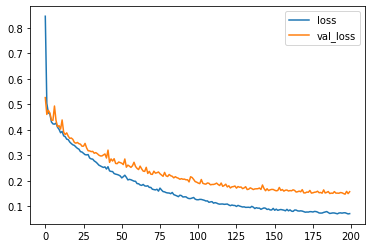

In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=100,
    epochs=200,
    verbose=1,
    )

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

model.save("model_TTT_sacks_under2sec.h5")

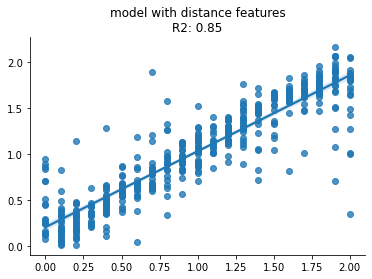

In [9]:
y_preds = model.predict(X_valid)
#y_preds = np.mean(np.mean(_y_preds,axis=2),axis=1)
#y_preds = _y_preds[:,5,0]

# calculate R2 to show explained variance
r2 = pearsonr(y_valid, y_preds)[0]**2

# plot data
sns.regplot(x=y_valid[:500], y=y_preds[:500])
plt.title(f"model with distance features\nR2: {round(r2[0], 3)}")
sns.despine()
plt.show()

(array([   0.,    0.,   10., 1271.,  846.,    7.,    0.,    0.]),
 array([-4, -3, -2, -1,  0,  1,  2,  3,  4]),
 <BarContainer object of 8 artists>)

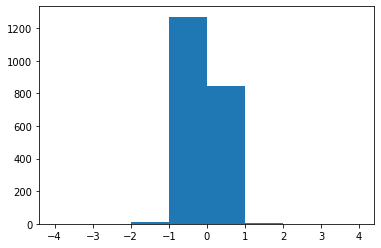

In [10]:
plt.hist(y_valid - y_preds.T[0],bins=np.arange(-4,5))

In [11]:
preds = model.predict(np.array(feats))
diff_ttc = np.array(target) - preds.T[0]
d = {'OL': OLteam,'DL': DLteam,'gpid': gpid}
df = pd.DataFrame(d)
df['diff_ttc'] = diff_ttc
#df.groupby(['DL']).sum().sort_values('diff_ttc', ascending=False)

In [12]:
play_ttc = df.groupby(['gpid']).sum().reset_index()
total_ttc = play_ttc.rename(columns={"diff_ttc": "total_ttc"})

In [13]:
df2 = df[['OL','DL','gpid']].drop_duplicates()
df_play = df2.merge(total_ttc, how='left')
_OL_ttc = df_play.groupby(['OL']).mean().sort_values('total_ttc', ascending=False)
OL_ttc = _OL_ttc.rename(columns={"total_ttc":"OL_ttc"})
OL_ttc.index.name = None
_DL_ttc = df_play.groupby(['DL']).mean().sort_values('total_ttc', ascending=False)
DL_ttc = _DL_ttc.rename(columns={"total_ttc":"DL_ttc"})
DL_ttc.index.name = None

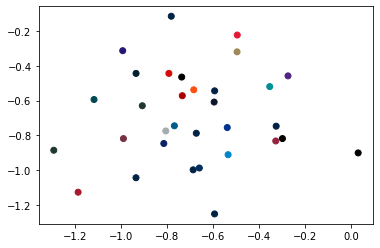

In [14]:
ttc_comp = DL_ttc.join(OL_ttc)
ttc_color = ttc_comp.join(teamcolors.set_index('team')['color'])
plt.scatter(ttc_color.DL_ttc,ttc_color.OL_ttc,color=ttc_color.color)

In [15]:
ttc_comp

,DL_ttc,OL_ttc
CIN,0.029431,-0.901023
MIN,-0.275003,-0.457795
JAX,-0.299145,-0.818434
DEN,-0.326378,-0.747176
ARI,-0.328212,-0.832285
MIA,-0.354289,-0.519493
KC,-0.495224,-0.222906
NO,-0.496134,-0.319554
CAR,-0.534969,-0.911205
BUF,-0.538631,-0.754972
